In [1]:
import os
import pandas as pd
import seaborn as sns
import tempfile
from qiime2 import Artifact
from qiime2.metadata import Metadata
from qiime2.plugins.feature_classifier.methods import classify_consensus_vsearch
from qiime2.plugins.taxa.visualizers import barplot
from qiime2 import Visualization
from scipy import stats

%matplotlib inline

In [2]:
working_dir = os.path.abspath('../')
refs_dir = working_dir + '/taxonomy_references'
metadata = Metadata.load(working_dir + '/input/qiime2/barcode_file.tsv')
references = ['silva', 'silva_extended', 'gg', 'gg_extended']
methods = ['dada2', 'deblur']#, 'unoise3']

In [3]:
for method in methods:
    ft = Artifact.load(working_dir + '/output/' + method + '_table.qza')
    seqs = Artifact.load(working_dir + '/output/' + method + '_rep_seqs.qza')
    for reference in references:
        ref_seqs = Artifact.load(refs_dir + '/' + reference + '_sequences.qza')
        ref_tax = Artifact.load(refs_dir + '/' + reference + '_taxonomy.qza')
        classification_taxonomy, = classify_consensus_vsearch(seqs, ref_seqs, ref_tax, threads = 12)
        classification_taxonomy.save(working_dir + '/output/' + method + '_' + reference + '_classification_taxonomy.qza')
        print(method, reference, 'done')

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-mjz8q72c/bb1f5d3d-85b2-4da6-9150-158a317e2eb1/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-w4ambbug/b41681fb-a4e7-4ef8-a23a-a26f1bcfd272/data/dna-sequences.fasta --threads 12 --output_no_hits --blast6out /tmp/tmprqb7moc_

dada2 silva done
Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-mjz8q72c/bb1f5d3d-85b2-4da6-9150-158a317e2eb1/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxr

In [4]:
df = metadata.to_dataframe()
df = df.drop(df.columns.difference(['#SampleID']), 1)
ids = Metadata(df)
for method in methods:
    ft = Artifact.load(working_dir + '/output/' + method + '_table.qza')
    for reference in references:
        taxonomy = Artifact.load(working_dir + '/output/' + method + '_' + reference + '_classification_taxonomy.qza')
        tbp, = barplot(ft, taxonomy, ids)
        tbp.save(working_dir + '/output/' + method + '_' + reference + '_tbp.qzv')

In [5]:
results = pd.DataFrame(columns = ['absolute unassigned', 'proportion unassigned',
                                  'absolute chloroplasts', 'proportion chloroplasts',
                                  'absolute mitochondria', 'proportion mitochondria',
                                  'denoise method', 'reference taxonomy']).rename_axis('#SampleID')
with tempfile.TemporaryDirectory() as temp_dir:
    for method in methods:
        method_results = pd.DataFrame().rename_axis('#SampleID')
        for reference in references:
            reference_results = pd.DataFrame().rename_axis('#SampleID')
            qzv = Visualization.load(working_dir + '/output/' + method + '_' + reference + '_tbp.qzv')
            qzv.export_data(temp_dir)
            df = pd.read_csv(temp_dir + '/level-1.csv', index_col = 0)
            df['total'] = df.sum(1)
            df['proportion unassigned'] = df['Unassigned'] / df['total']
            reference_results['absolute unassigned'] = df['Unassigned']
            reference_results['proportion unassigned'] = df['proportion unassigned']
            if 'silva' in reference:
                df = pd.read_csv(temp_dir + '/level-4.csv', index_col = 0)
                df['total'] = df.sum(1)
                df['proportion chloroplasts'] = df['d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Chloroplast'] / df['total']
                reference_results['absolute chloroplasts'] = df['d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Chloroplast']
            else:
                df = pd.read_csv(temp_dir + '/level-3.csv', index_col = 0)
                df['total'] = df.sum(1)
                df['proportion chloroplasts'] = df['k__Bacteria;p__Cyanobacteria;c__Chloroplast'] / df['total']
                reference_results['absolute chloroplasts'] = df['k__Bacteria;p__Cyanobacteria;c__Chloroplast']
            reference_results['proportion chloroplasts'] = df['proportion chloroplasts']
            df = pd.read_csv(temp_dir + '/level-5.csv', index_col = 0)
            df['total'] = df.sum(1)
            if 'silva' in reference:
                if 'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria' in df.columns:
                    df['proportion mitochondria'] = df['d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria'] / df['total']
                    reference_results['absolute mitochondria'] = df['d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria']
                else:
                    df['proportion mitochondria'] = 0
                    reference_results['absolute mitochondria'] = 0
            else:
                if 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__mitochondria' in df.columns:
                    df['proportion mitochondria'] = df['k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__mitochondria'] / df['total']
                    reference_results['absolute mitochondria'] = df['k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__mitochondria']
                else:
                    df['proportion mitochondria'] = 0
                    reference_results['absolute mitochondria'] = 0
            reference_results['proportion mitochondria'] = df['proportion mitochondria']
            reference_results['reference taxonomy'] = reference
            method_results = method_results.append(reference_results)
        method_results['denoise method'] = method
        results = results.append(method_results)
    md = pd.read_csv(working_dir + '/input/qiime2/barcode_file.tsv',
                     '\t', index_col = 0)
    results_with_metadata = results.merge(md, 'left', left_index = True,
                                          right_index = True).rename_axis('sample-id')
    results_with_metadata.to_csv(working_dir + '/output/proportions.csv')

In [16]:
df

,absolute unassigned,proportion unassigned,absolute chloroplasts,proportion chloroplasts,absolute mitochondria,proportion mitochondria,denoise method,reference taxonomy,barcode,center_name,experiment_design_description,instrument_model,library_construction_protocol,pcr_primers,platform,primer,qiita_prep_id,sequencing_meth,target_gene,target_subfragment
sample-id,,,,,,,,,,,,,,,,,,,,
12366.1985,120.0,0.014208,9.0,0.001066,0.0,0.000000,dada2,silva,ACACACAC,UC Davis Marco Lab,Milk microbiota and slits,Illumina MiSeq,"Illumina MiSeq 515fbc, 806r amplification of 1...",FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,GTGCCAGCMGCCGCGGTAA,6501,Sequencing by synthesis,16S rRNA,V4
12366.1985,120.0,0.014208,9.0,0.001066,0.0,0.000000,dada2,silva_extended,ACACACAC,UC Davis Marco Lab,Milk microbiota and slits,Illumina MiSeq,"Illumina MiSeq 515fbc, 806r amplification of 1...",FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,GTGCCAGCMGCCGCGGTAA,6501,Sequencing by synthesis,16S rRNA,V4
12366.1985,120.0,0.014208,0.0,0.000000,0.0,0.000000,dada2,gg,ACACACAC,UC Davis Marco Lab,Milk microbiota and slits,Illumina MiSeq,"Illumina MiSeq 515fbc, 806r amplification of 1...",FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,GTGCCAGCMGCCGCGGTAA,6501,Sequencing by synthesis,16S rRNA,V4
12366.1985,44.0,0.005210,73.0,0.008643,76.0,0.008998,dada2,gg_extended,ACACACAC,UC Davis Marco Lab,Milk microbiota and slits,Illumina MiSeq,"Illumina MiSeq 515fbc, 806r amplification of 1...",FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,GTGCCAGCMGCCGCGGTAA,6501,Sequencing by synthesis,16S rRNA,V4
12366.1985,19.0,0.003278,0.0,0.000000,0.0,0.000000,deblur,silva,ACACACAC,UC Davis Marco Lab,Milk microbiota and slits,Illumina MiSeq,"Illumina MiSeq 515fbc, 806r amplification of 1...",FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,GTGCCAGCMGCCGCGGTAA,6501,Sequencing by synthesis,16S rRNA,V4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12366.2206,2.0,0.000294,0.0,0.000000,0.0,0.000000,dada2,gg_extended,ATGCAAGG,UC Davis Marco Lab,Milk microbiota and slits,Illumina MiSeq,"Illumina MiSeq 515fbc, 806r amplification of 1...",FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,GTGCCAGCMGCCGCGGTAA,6501,Sequencing by synthesis,16S rRNA,V4
12366.2206,0.0,0.000000,0.0,0.000000,0.0,0.000000,deblur,silva,ATGCAAGG,UC Davis Marco Lab,Milk microbiota and slits,Illumina MiSeq,"Illumina MiSeq 515fbc, 806r amplification of 1...",FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,GTGCCAGCMGCCGCGGTAA,6501,Sequencing by synthesis,16S rRNA,V4
12366.2206,0.0,0.000000,0.0,0.000000,0.0,0.000000,deblur,silva_extended,ATGCAAGG,UC Davis Marco Lab,Milk microbiota and slits,Illumina MiSeq,"Illumina MiSeq 515fbc, 806r amplification of 1...",FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,Illumina,GTGCCAGCMGCCGCGGTAA,6501,Sequencing by synthesis,16S rRNA,V4


In [39]:
base_absolute = df.groupby(['reference taxonomy', 'denoise method'])['absolute ' + level].sum()[base_reference, method]
#float(base_absolute)

0.0

In [43]:
base_proportion = df['proportion ' + level][(df['reference taxonomy'] == base_reference) & (df['denoise method'] == method)]
base_proportion

sample-id
12366.1985    0.0
12366.1986    0.0
12366.1989    0.0
12366.1990    0.0
12366.1993    0.0
             ... 
12366.2198    0.0
12366.2201    0.0
12366.2202    0.0
12366.2205    0.0
12366.2206    0.0
Name: proportion mitochondria, Length: 104, dtype: float64

In [52]:
df = pd.read_csv((working_dir + '/output/proportions.csv'), index_col = 0)
statistics = []
for method in methods:
    for level in ['unassigned', 'chloroplasts', 'mitochondria']:
        for base_reference in ['silva', 'gg']:
            base_absolute = sum(df['absolute ' + level][(df['reference taxonomy'] == base_reference) & (df['denoise method'] == method)])
            #base_absolute = df.groupby(['reference taxonomy', 'denoise method'])['absolute ' + level].sum()[base_reference, method]
            extended_absolute = sum(df['absolute ' + level][(df['reference taxonomy'] == (base_reference + '_extended')) & (df['denoise method'] == method)])
                                #df.groupby(['reference taxonomy', 'denoise method'])['absolute ' + level].sum()[base_reference + '_extended', method]
            if not base_absolute == 0:
                fold_delta = extended_absolute / base_absolute
            else:
                fold_delta = 0
            base_proportion = df['proportion ' + level][(df['reference taxonomy'] == base_reference) & (df['denoise method'] == method)]
            extended_proportion = df['proportion ' + level][(df['reference taxonomy'] == (base_reference + '_extended')) & (df['denoise method'] == method)]
            if not ((sum(base_proportion) == 0) & (sum(extended_proportion) == 0)):
                H, p = stats.kruskal(base_proportion, extended_proportion)
            else:
                H, p = None, 1
            statistics.append((method, level, base_reference, fold_delta, H, p, (p*18 if p*18<1 else 1.0)))
stats_df = pd.DataFrame(statistics, columns = ['denoise method', 'level', 'base reference', 'extended/base counts', 'H', 'p', 'bonferroni p'])
stats_df

,denoise method,level,base reference,extended/base counts,H,p,bonferroni p
0,dada2,unassigned,silva,0.961619,0.000374,9.845745e-01,1.000000e+00
1,dada2,unassigned,gg,0.199607,20.005710,7.721125e-06,1.389803e-04
2,dada2,chloroplasts,silva,3.247423,1.039155,3.080180e-01,1.000000e+00
3,dada2,chloroplasts,gg,20.750000,31.428325,2.069399e-08,3.724918e-07
4,dada2,mitochondria,silva,0.000000,1.000000,3.173105e-01,1.000000e+00
5,dada2,mitochondria,gg,0.000000,106.890242,4.705197e-25,8.469355e-24
6,deblur,unassigned,silva,1.000000,0.000000,1.000000e+00,1.000000e+00
7,deblur,unassigned,gg,0.978261,0.012191,9.120816e-01,1.000000e+00
8,deblur,chloroplasts,silva,2.445652,1.291147,2.558367e-01,1.000000e+00
9,deblur,chloroplasts,gg,9.698113,15.263279,9.351695e-05,1.683305e-03


In [53]:
sns.set_style("dark")
sns.set_context("poster")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [54]:
dada2_df = df[df['denoise method'] == 'dada2']
deblur_df = df[df['denoise method'] == 'deblur']

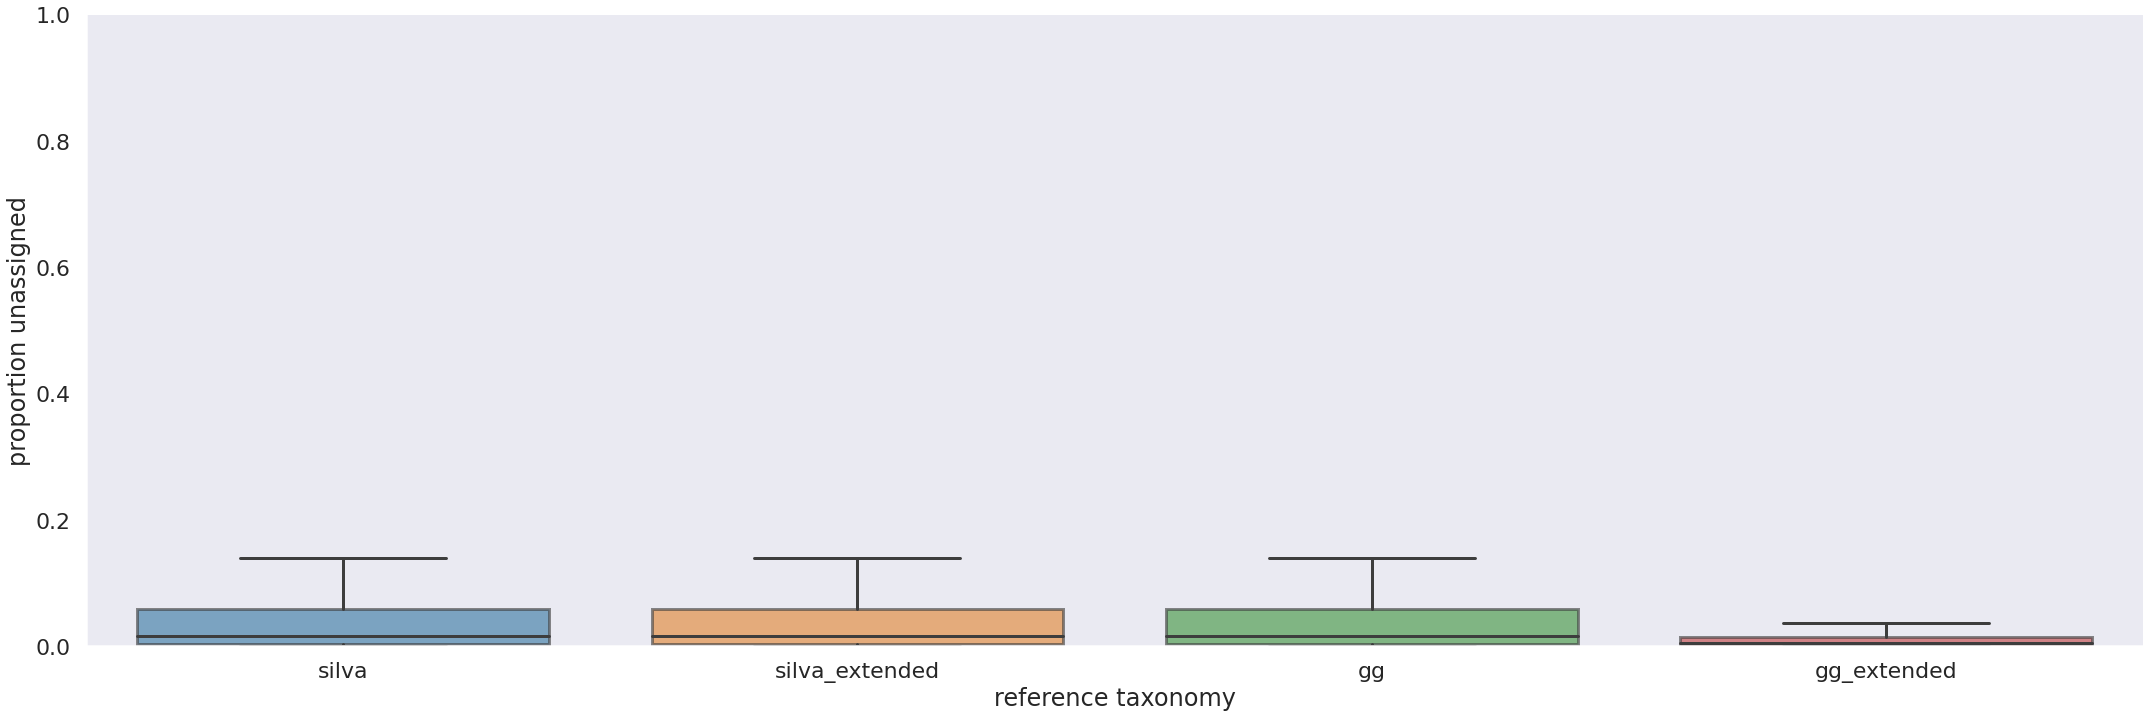

In [55]:
g = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion unassigned",
                kind = "box", data = dada2_df, fliersize = 0)
g.set(ylim = (0, 1))

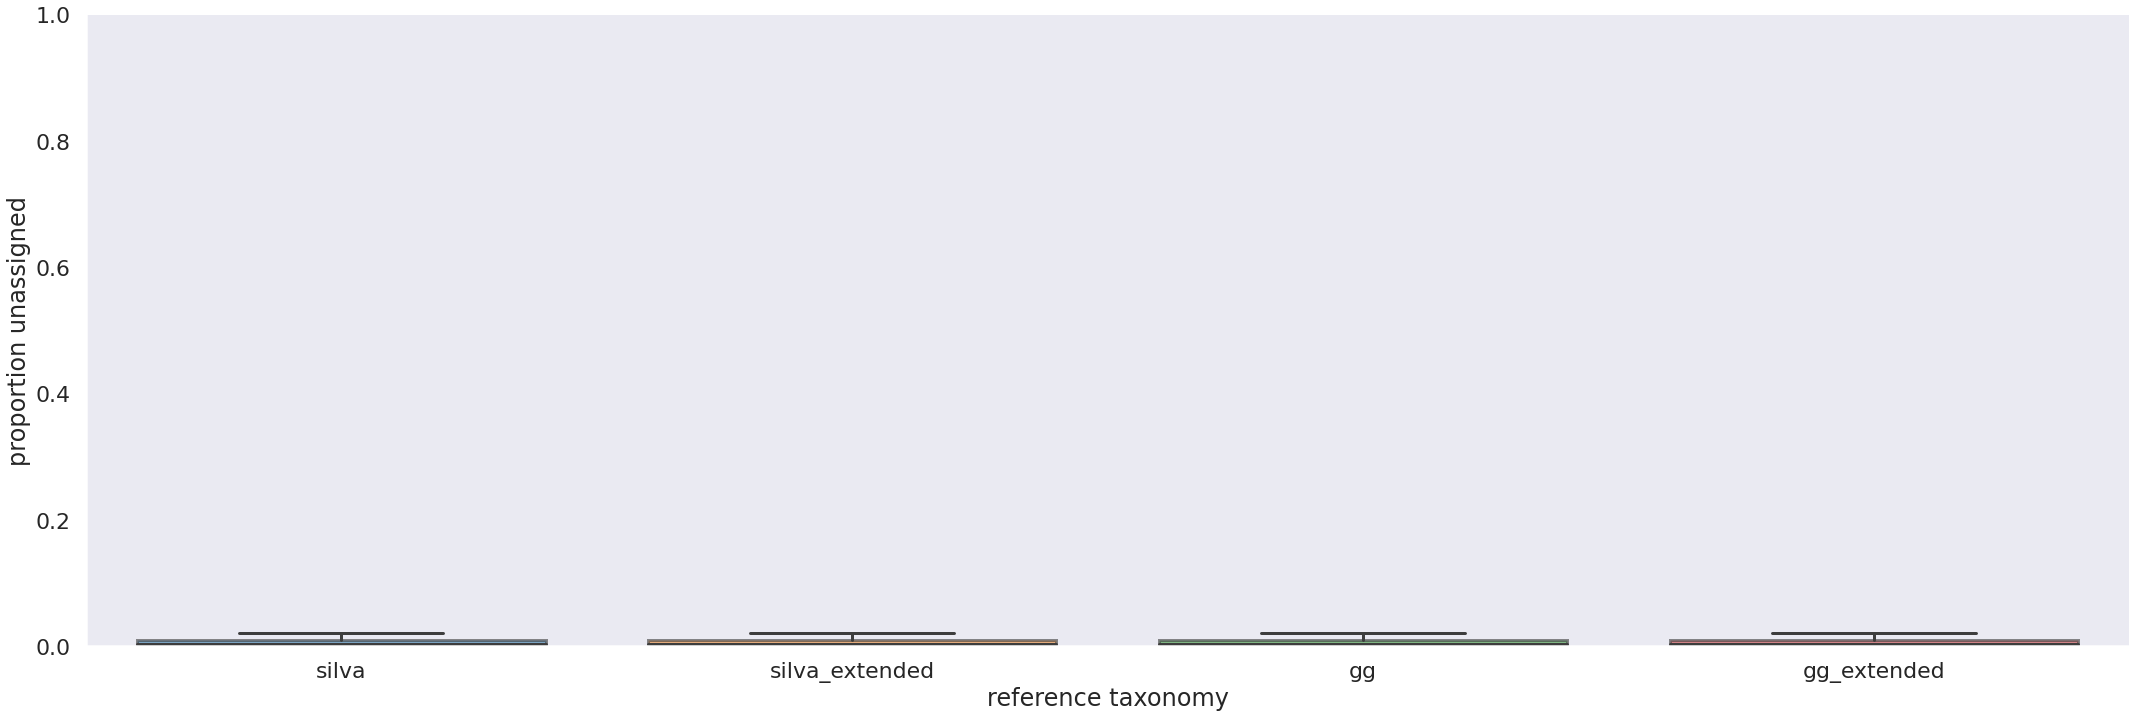

In [56]:
h = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion unassigned",
                kind = "box", data = deblur_df, fliersize = 0)
h.set(ylim = (0, 1))

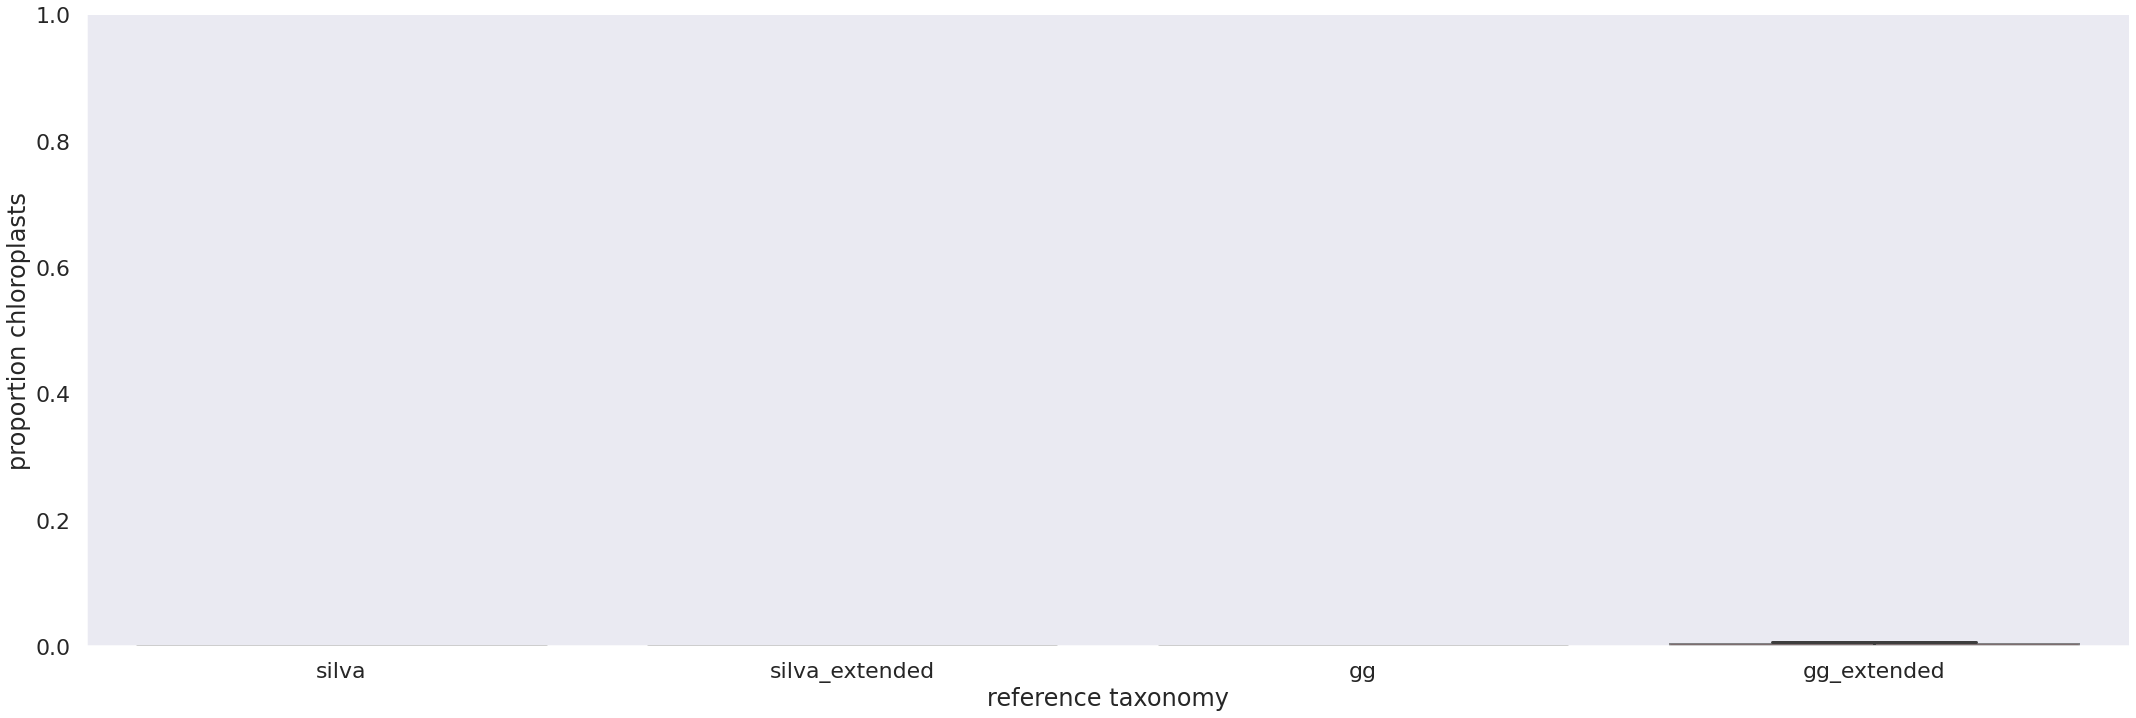

In [57]:
i = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion chloroplasts",
                kind = "box", data = dada2_df, fliersize = 0)
i.set(ylim = (0, 1))

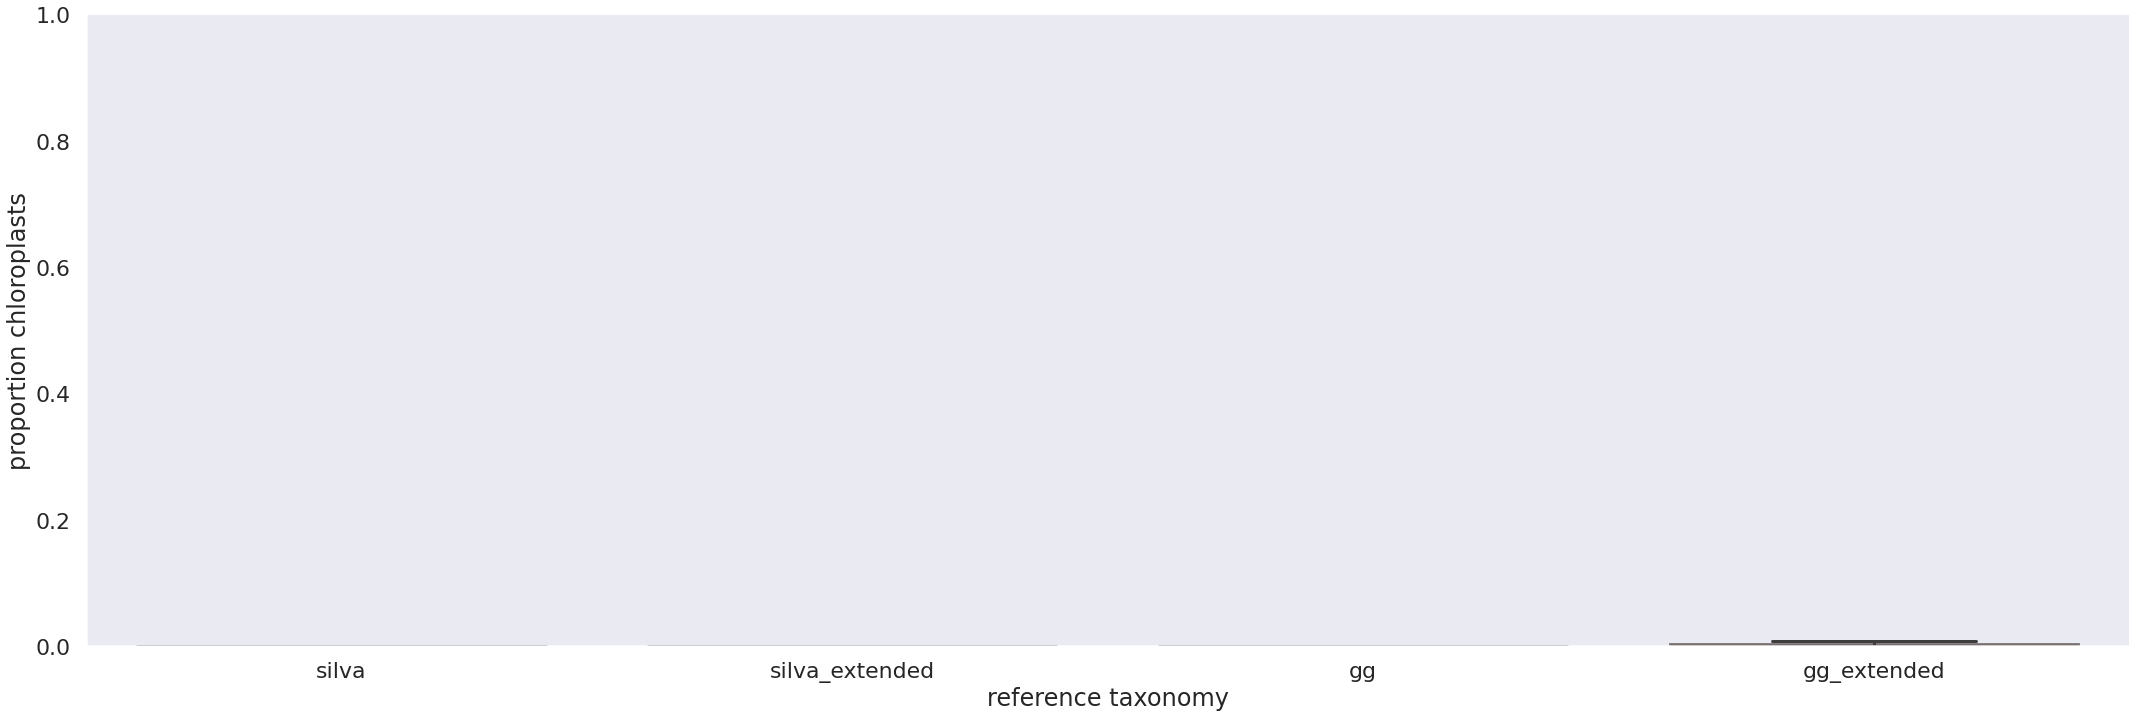

In [58]:
j = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion chloroplasts",
                kind = "box", data = deblur_df, fliersize = 0)
j.set(ylim = (0, 1))

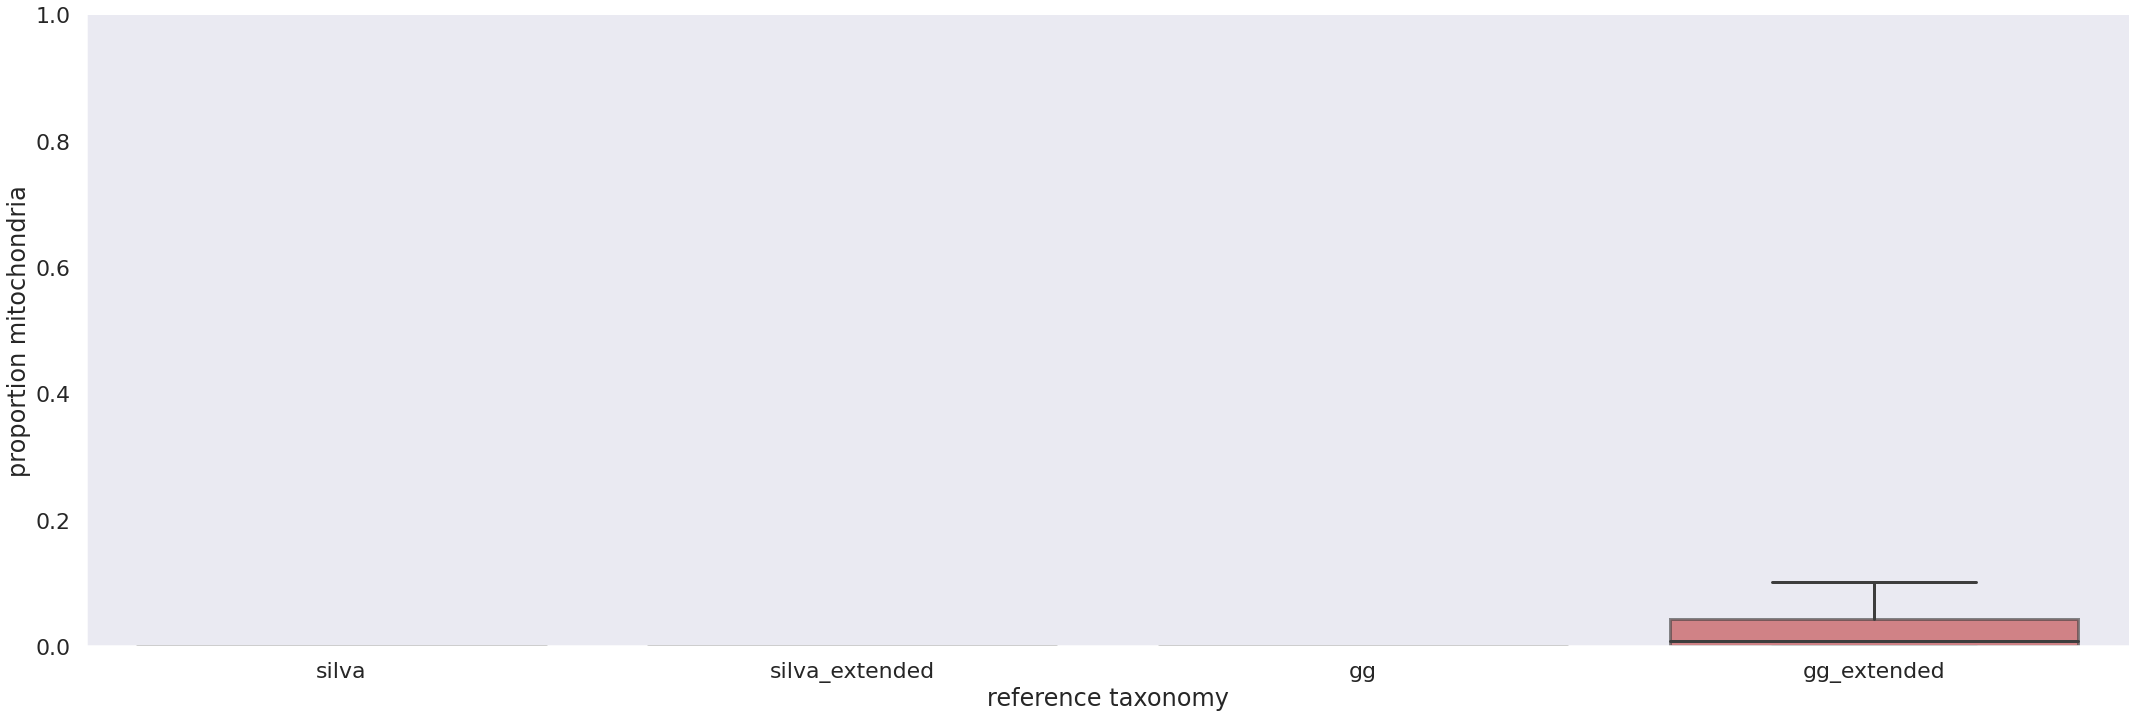

In [59]:
k = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion mitochondria",
                kind = "box", data = dada2_df, fliersize = 0)
k.set(ylim = (0, 1))

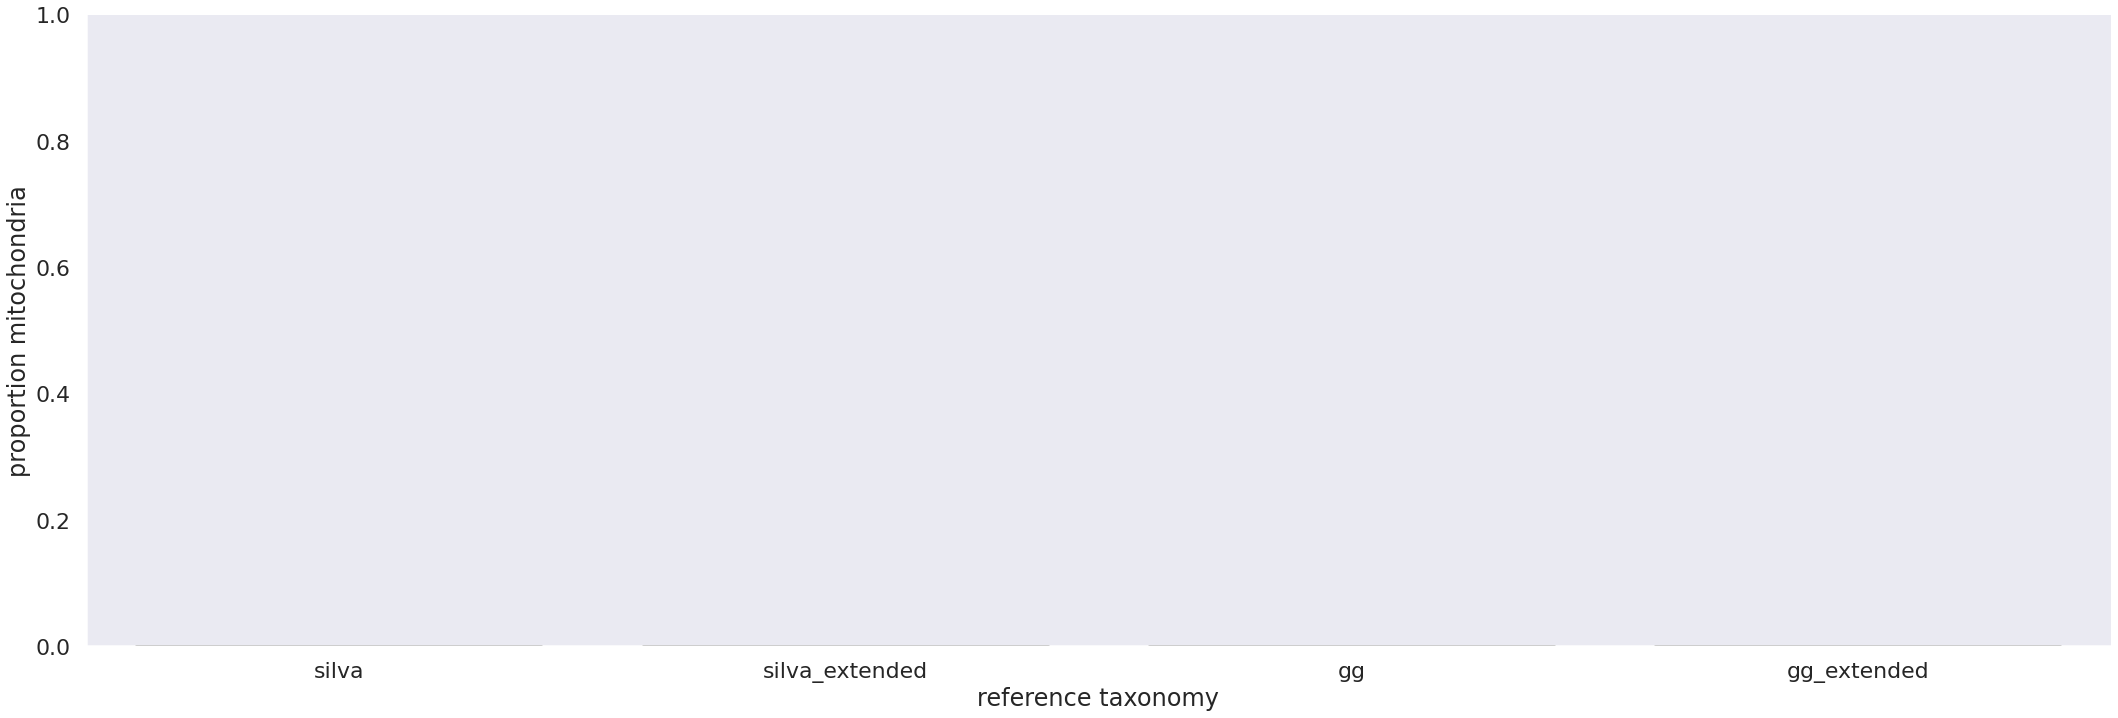

In [60]:
l = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion mitochondria",
                kind = "box", data = deblur_df, fliersize = 0)
l.set(ylim = (0, 1))